上一节中提提到的过拟合现象，在模型的训练误差远小于测试集上的误差。虽然增大训练接数据集可以减轻过拟合，但是获得额外的训练数据往往代价过大，本节介绍过拟合常用的方式:权重衰减(weight decay)。

##### 权重衰减

权重衰减等价于L2范数正则化(regularzation)。正则化通过模型损失函数添加惩罚项使学到的模型参数值较小，是应对过拟合的常用方法，我们先描述L2范数正则化，再解释它为何称为权重衰减。
L2范数正则化在模型原损失函数的基础上添加L2范数惩罚项，从而得到训练得到所需的最小化函数。L2范数惩罚项是模型权重参数每个元素的平凡和与一个正的常数的乘积。以线性回归中线性回归损失函数
$l(w_{1},w_{2},b )= \frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(x_{1}^{(i)}w_{1}+x_{2}^{(i)}w_{2} +b - y^{(i)})^{2}$ ，其中w1,w2是权重参数，b为偏置，样本i的输入为$x_{1}^{(i)},x_{2}^{(i)},标签是y^{(i)}，样本数为n，将权重参数向量w=[w_{1},w_{2}]表示，$带有L2范数惩罚项的新损失函数为
$$l(w_{1},w_{2},b )+\frac{\lambda}{2n}\|\boldsymbol{w}\|^{2}$$
其中超参数为λ>0。当权重参数均为0时，惩罚项最小。当λ较大时，惩罚项在损失函数中的权重较大，通常会使学习到的权重参数的元素较接近0；当λ设为0时，惩罚项完全不起作用。上式中L2范数平方$$\|w\|^{2}展开后得到w_{1}^{2}+w_{2}^{2}$$
有了L2范数惩罚项后，在小批量随机梯度下降汇总，我们将线性回归一节中权重w1和w2的迭代方式更改为
$$
\begin{array} { l } { w _ { 1 } \leftarrow \left( 1 - \frac { \eta \lambda } { | \mathcal { B } | } \right) w _ { 1 } - \frac { \eta } { | \mathcal { B } | } \sum _ { i \in \mathcal { B } } x _ { 1 } ^ { ( i ) } \left( x _ { 1 } ^ { ( i ) } w _ { 1 } + x _ { 2 } ^ { ( i ) } w _ { 2 } + b - y ^ { ( i ) } \right) } \\ { w _ { 2 } \leftarrow \left( 1 - \frac { \eta \lambda } { | \mathcal { B } | } \right) w _ { 2 } - \frac { \eta } { | \mathcal { B } | } \sum _ { i \in \mathcal { B } } x _ { 2 } ^ { ( i ) } \left( x _ { 1 } ^ { ( i ) } w _ { 1 } + x _ { 2 } ^ { ( i ) } w _ { 2 } + b - y ^ { ( i ) } \right) } \end{array}
$$

可见，L2范数正则化令权重w1和w2先自乘一个小于1的数，再减去不含惩罚项的梯度。因此L2范数正则化又叫做权重衰减。有时候在惩罚项中也添加偏置元素的平方和。

##### 高维线性回归实验

高纬线性过拟合数据，并使用权重衰减来应对过拟合。设定特征的维度为p,对于训练和测试数据中特征为$x_{1},x_{2},x_{3},,,,,x_{p}$的任一样本，我们使用如下的形象函数来生成该样本的标签：
$y = 0.05+\sum_{i=1}^{p}0.01x_{i}+\epsilon，
其中噪音项\epsilon$服从均值为0，标准差为0.01的正态分布。为了较容易的观察过拟合，我们考虑高纬线性回归问题，设定维度200，同时故意把训练数据集的样本降低为20。

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import  numpy as np
import sys 
sys.path.append('..')
import d2lzh_pytorch as d2l


In [2]:
n_train,n_test,num_inputs = 20,100,200   # 训练，测试样本，数据维度
true_w ,true_b = torch.ones(num_inputs,1)*0.01 , 0.05


features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

##### 从零开始实现

从零开始实现权重衰减的方法，在目标函数后添加L2范数惩罚项来实现权重衰减。

###### 初始化模型参数

In [3]:
def init_params():
    w = torch.randn((num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

###### 定义L2范数惩罚项

In [4]:
def l2_penalty(w):
    return (w**2).sum()/2

In [5]:
def linreg(X,w,b):
    return torch.mm(X,w)+b


def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2/2

def sgd(params,lr,batch_size):
    for param in params:
        param.data -=lr* param.grad/batch_size  

        
        #定义作图函数 semiplgy 其中y轴使用了对数尺度
def semilogy(x,y,x_label,y_label,x2=None,y2=None,legend=None,figsize=(3.5,2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x,y)
    if x2 and y2:
        d2l.plt.semilogy(x2,y2,linestyle=':')
        d2l.plt.legend(legend)


###### 定义训练和测试

In [6]:
batch_size,num_epochs ,lr =1,100,0.003
net,loss = linreg,squared_loss

In [7]:
dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)


In [8]:
def fit_and_plot(lambd):
    w,b = init_params()
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:

            #l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = loss(net(X,w,b),y)+lambd*l2_penalty(w)
            l=l.sum()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features,w,b),train_labels).mean().item())
        test_ls.append(loss(net(test_features,w,b),test_labels).mean().item())
        
    semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',
                range(1,num_epochs+1),test_ls,['train','test'])
    print("L2 norm of w",w.norm().item())

L2 norm of w 13.360041618347168


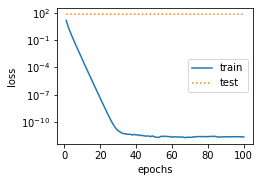

In [9]:
fit_and_plot(lambd=0)

###### 使用权重衰减

L2 norm of w 0.0406213141977787


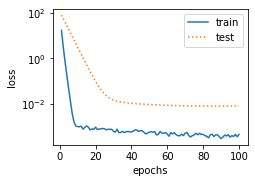

In [10]:
fit_and_plot(lambd=3)
# 训练集的误差有所提高，但是测试集上的误差同样下降，过拟合的现象在一定程度上缓解，
#另外权重参数L2范数比不适用权重衰减更小，此时的权重参数更加接近0

##### pytorch简洁实现

这里我们直接在构造优化器实例时通过weight_decay参数来指定权重衰减超参数，默认是pytorch会对权重和偏置同事衰减。我们可以分别对权重和偏置购置优化器实例，从而只对权重衰减。

In [16]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs,1)
    nn.init.normal_(net.weight,mean=0,std=1)
    nn.init.normal_(net.bias,mean=0,std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight],lr=lr,weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias],lr=lr)
    
    
    train_ls ,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            optimizer_b.step()
            optimizer_w.step()
            
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
    semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',
                range(1,num_epochs+1),test_ls,['train','test'])
    print("L2 norm of w",net.weight.data.norm().item())

L2 norm of w 13.489049911499023


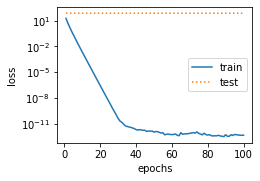

In [17]:
fit_and_plot_pytorch(0)

L2 norm of w 0.13610510528087616


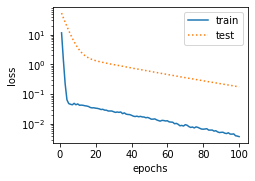

In [18]:
fit_and_plot_pytorch(3)

##### 小结

- 正则化通过为模型损失函数中添加惩罚项使学习到的模型参数值较小，是对应过拟合的常用方法
- 权重衰减等于L2范数正则化，通常使学习到的权重参数接近0
- 权重衰减可以通过优化器的weight_decay超参数来指定
- 可以定义多个优化器实例对不同的模型参数使用不同的迭代方法